In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
excel_data = pd.read_excel(r'C:\Users\NEW\Desktop\data.xlsx')
excel_data.head()

,Company,Year,Water_consumption per vehicle,GHG emission per vehicle,"Social:Labor Practices (1,0)",Social: Gender Diversity (female%),"Governance: Transparency (1,0)",Governance: Leadership Diversity (Female%)
0,Tesla,2023,2.10,0.367,1,23.0,1,21.0
1,Tesla,2022,2.46,0.445,1,20.0,1,25.0
2,Tesla,2021,3.09,0.632,1,22.0,1,25.0
3,Tesla,2020,4.08,1.059,1,21.0,1,17.0
4,Tesla,2019,4.83,1.439,1,21.0,1,17.0


In [17]:
median_c = excel_data["Water_consumption per vehicle"].median()
median_d = excel_data["GHG emission per vehicle"].median()
median_f = excel_data["Social: Gender Diversity (female%)"].median()
median_h = excel_data["Governance: Leadership Diversity (Female%)"].median()
# Calculate scores for each group
def calculate_group_scores(data, median_c, median_d, median_f, median_h):
    group_scores = {'C_D_Score': [], 'E_F_Score': [], 'G_H_Score': []}
    for _, row in data.iterrows():
        # C and D group score
        c_score = 25 if row['Water_consumption per vehicle'] <= median_c else max(15, 25 - (row['Water_consumption per vehicle'] - median_c) / median_c * 25)
        d_score = 25 if row['GHG emission per vehicle'] <= median_d else max(15, 25 - (row['GHG emission per vehicle'] - median_d) / median_d * 25)
        group_scores['C_D_Score'].append(round(c_score + d_score))

        # E and F group score
        e_score = 12.5  # Full score for E
        f_score = 12.5 if row['Social: Gender Diversity (female%)'] >= median_f else max(7.5, 12.5 - (median_f - row['Social: Gender Diversity (female%)']) / median_f * 12.5)
        group_scores['E_F_Score'].append(round(e_score + f_score))

        # G and H group score
        g_score = 12.5  # Full score for G
        h_score = 12.5 if row['Governance: Leadership Diversity (Female%)'] >= median_h else max(7.5, 12.5 - (median_h - row['Governance: Leadership Diversity (Female%)']) / median_h * 12.5)
        group_scores['G_H_Score'].append(round(g_score + h_score))

    return group_scores

# Calculate group scores and add to the dataframe
group_scores = calculate_group_scores(excel_data, median_c, median_d, median_f, median_h)
excel_data['C_D_Score'] = group_scores['C_D_Score']
excel_data['E_F_Score'] = group_scores['E_F_Score']
excel_data['G_H_Score'] = group_scores['G_H_Score']

def calculate_esg_score(row, median_c, median_d, median_f, median_h):
    # Initialize scores
    c_score = 25
    d_score = 25
    f_score = 12.5
    h_score = 12.5

    # Calculate C column score
    if row['Water_consumption per vehicle'] > median_c:
        deduction = (row['Water_consumption per vehicle'] - median_c) / median_c * 25
        c_score = max(15, c_score - deduction)

    # Calculate D column score
    if row['GHG emission per vehicle'] > median_d:
        deduction = (row['GHG emission per vehicle'] - median_d) / median_d * 25
        d_score = max(15, d_score - deduction)

    # Calculate F column score
    if row['Social: Gender Diversity (female%)'] < median_f:
        deduction = (median_f - row['Social: Gender Diversity (female%)']) / median_f * 12.5
        f_score = max(7.5, f_score - deduction)

    # Calculate H column score
    if row['Governance: Leadership Diversity (Female%)'] < median_h:
        deduction = (median_h - row['Governance: Leadership Diversity (Female%)']) / median_h * 12.5
        h_score = max(7.5, h_score - deduction)

    # E and G columns are full scores
    e_score = 12.5
    g_score = 12.5

    # Total ESG score
    total_score = round(c_score + d_score + e_score + f_score + g_score + h_score)
    return total_score

# Apply the function to calculate ESG scores
excel_data['ESG_Score'] = excel_data.apply(
    calculate_esg_score, axis=1, args=(median_c, median_d, median_f, median_h)
)
excel_data
excel_data.to_excel(r'C:\Users\NEW\Desktop\calculated_esg_scores.xlsx', index=False)

In [18]:
# Calculate average scores for each company
summary_data = excel_data.groupby('Company').agg(
    ESG_Score=('ESG_Score', 'mean'),
    E_Score=('C_D_Score', 'mean'),
    S_Score=('E_F_Score', 'mean'),
    G_Score=('G_H_Score', 'mean')
).reset_index()
summary_data = summary_data.round()
for company in ['Mercedes-Benz', 'Xiaopeng']:
    row = summary_data[summary_data['Company'] == company]
    branch_sum = row[['E_Score', 'S_Score', 'G_Score']].sum(axis=1).values[0]
    total_score = row['ESG_Score'].values[0]
    if branch_sum != total_score:
        diff = total_score - branch_sum
        summary_data.loc[summary_data['Company'] == company, 'G_Score'] += diff
# Save the summary data to a new Excel file
summary_data.to_excel(r'C:\Users\NEW\Desktop\company_scores_summary.xlsx', index=False)

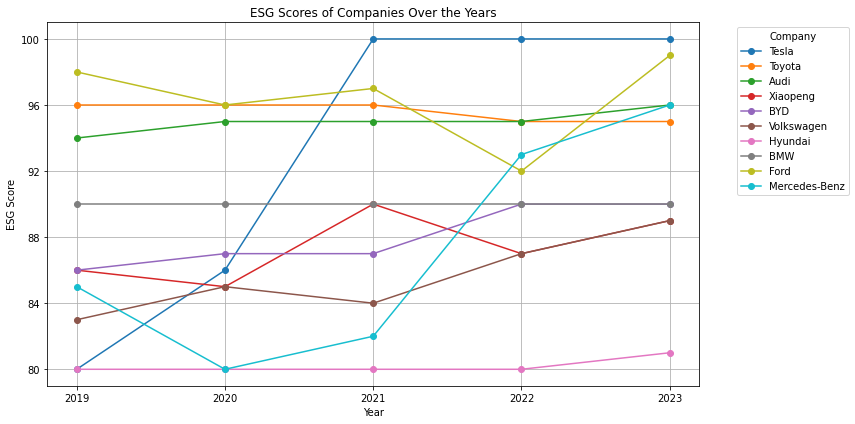

In [19]:
# Visualize ESG scores for each company over the years
plt.figure(figsize=(12, 6))
for company in excel_data['Company'].unique():
    company_data = excel_data[excel_data['Company'] == company]
    plt.plot(company_data['Year'], company_data['ESG_Score'], marker='o', label=company)
plt.title('ESG Scores of Companies Over the Years')
plt.yticks(ticks=np.arange(80, 101, 4))
plt.xticks(ticks=company_data['Year'], labels=company_data['Year'].astype(int))
plt.xlabel('Year')
plt.ylabel('ESG Score')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()